# Manual implementation of the softmax function

In this notebook we explore implementing the softmax function from scratch.

First, let's import the required libraries.

In [65]:
import numpy as np
import numpy.matlib # Used for repmat
import matplotlib.pyplot as plt
import math
import torch

Here is the equation for the softmax function.

$\Huge \sigma(z_i) = \frac{e^{z_i}}{\sum_{j=1}^{n} e^{z_j}} n$

As you can see, we use the exponential function specifically to handle negative logits (raw outputs from the previous layer). These will always be converted into positive values, which are a requirement for probabilities. The exponential function is also monotonic which is crucial here, meaning the contribution from each logit will remain consistent relative to the other logits. Additionally, the exponential function accentuates differences between logits. For instance, small differences in logits become much larger differences in $e^{z_i}$ which sharpens the distinction between the probabilities assigned to different classes.

Note that $\Huge \sigma$ is used here to represent the softmax output. This is common when describing a transformation of raw values (logits in this case) to a probability distribution. In this context it has nothing to do with variance or standard deviation.

## Input data (logits)

Let's say we have a vector of logits that is the output of the last hidden layer of a neural network:

In [66]:
logits = np.array([1.3, 5.1, 2.2, 0.7, 1.1])

## Visualisation of the softmax function

We can define a softmax function to convert these raw logit values into a probability distribution.

In [67]:
# Softmax function to convert logits to probabilities
def softmax(logits):
    exp_logits = np.exp(logits - np.max(logits))  # Subtract max for numerical stability
    return exp_logits / exp_logits.sum()

Let's use this to calculate the probabilities for the vector we defined earlier, and plot the results.

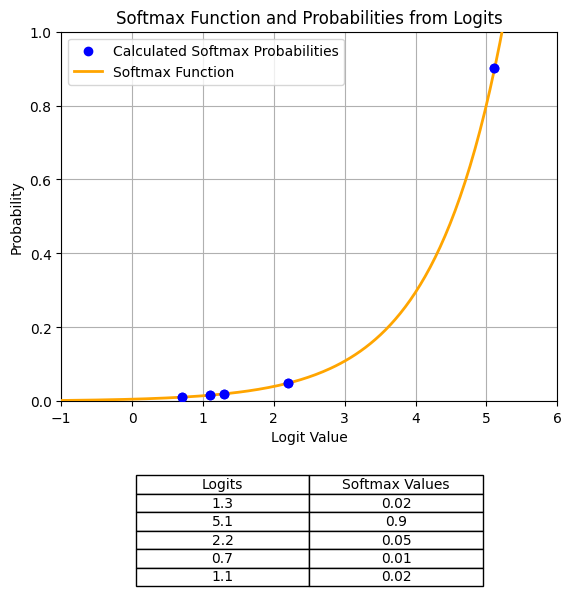

In [68]:
# Calculate probabilities for the original logits and round
probabilities = softmax(logits)
rounded_probabilities = np.round(probabilities, 2)

# Create a range of logits for the continuous softmax function
logit_range = np.linspace(-1, 6, 200)  # Extended range for smooth line
softmax_values = softmax(logit_range) * 63 # 63 is scaling factor

# Scatter plot with original logits on x-axis
plt.scatter(logits, probabilities, color='blue', label='Calculated Softmax Probabilities', zorder=5)
# Plot the continuous softmax function (from the logit range)
plt.plot(logit_range, softmax_values, color='orange', linestyle='-', linewidth=2, label='Softmax Function', zorder=4)

# Overlay the softmax values for the original logits
plt.scatter(logits, probabilities, color='blue', zorder=6)  # Blue points for the original logits

# Table data
table_data = np.column_stack((logits, rounded_probabilities))
columns = ['Logits', 'Softmax Values']

# Create a table
table = plt.table(cellText=table_data,
                  colLabels=columns,
                  cellLoc='center',
                  loc='bottom',
                  bbox=[0.15, -0.5, 0.7, 0.3])  # Adjust bbox for placement with more padding

# Table formatting
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)  # Scale the table size

# Add titles and labels
plt.title('Softmax Function and Probabilities from Logits')
plt.xlabel('Logit Value')
plt.ylabel('Probability')
plt.xlim(-1, 6)  # Adjust x-axis limits for better visibility
plt.ylim(0, 1)  # Ensure y-axis is between 0 and 1
plt.grid(True)
plt.legend()  
plt.show()

Note that the plot of softmax functions is similar to the exponential funcion. I initially mistakenly thought that the *sigmoid* function was actually the softmax function because this is the function that is commonly displayed when doing a Google search for example. This is probably because the sigmoid function describes the *path* of each softmax value as it increases/decreases. See [this timestamped video](https://youtu.be/ytbYRIN0N4g?t=162) for an example animation of this.

Here is an example of how to define the sigmoid function and it's plot.

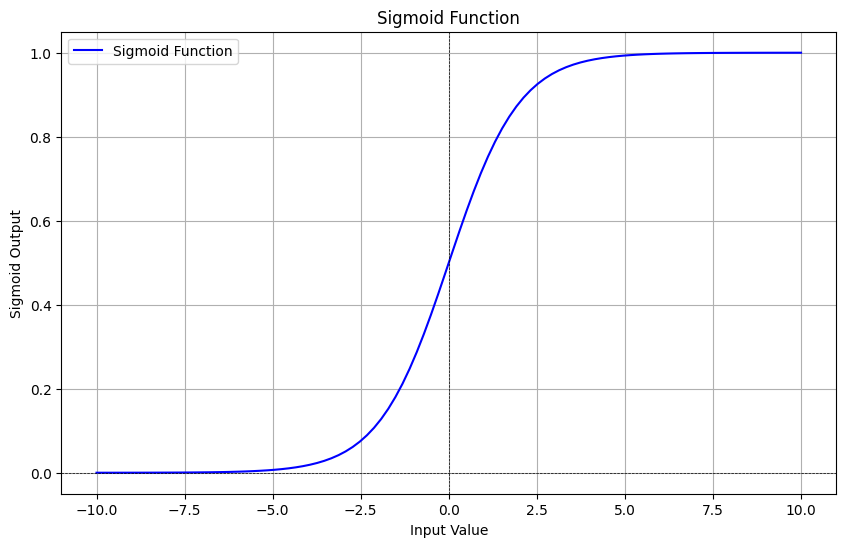

In [70]:
# Define the sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Generate a range of values
x = np.linspace(-10, 10, 100)
y = sigmoid(x)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(x, y, label='Sigmoid Function', color='blue')
plt.title('Sigmoid Function')
plt.xlabel('Input Value')
plt.ylabel('Sigmoid Output')
plt.axhline(0, color='black', lw=0.5, ls='--')
plt.axvline(0, color='black', lw=0.5, ls='--')
plt.grid()
plt.legend()
plt.show()

## UDL book softmax problem

In the UDL 5_3 notebook the softmax problem was a little confusing at first because of the usage of the [np.matlib.repmat](https://numpy.org/doc/stable/reference/generated/numpy.matlib.repmat.html) function.

As we've seen above, the softmax function is fairly straight forward when calculating for a single vector. In the UDL 5_3 problem though the input to the softmax function is a `3x100` matrix. This is because it computes ALL 100 inputs (`x`) at once, and each input has an asscociated vector of 3 values (one for each class).

So, we start by passing an input matrix of `3x100` into the softmax function and we need to compute the numerator and denominator for ALL 100 inputs simultaneously. The numerator for the softmax is just the exponential of the input vector (raw model outputs, or logits).

```python
exp_model_out = np.exp(model_out);
```

Then we need to compute the denominator, which is the sum of the 3 exponentiated outputs for each of the 100 inputs.

```python
sum_exp_model_out = np.sum(exp_model_out, axis=0)
```

However, this results in a matrix that is not `3x100`, but just a vector of length 100 elements, so we need to 'reshape' it to be `3x100`. This is where the `np.matlib.repmat` function comes into play.

```python
np.matlib.repmat(sum_exp_model_out, exp_model_out.shape[0], 1)
```

This function takes in the `sum_exp_model_out` vector (length=100) and replicates it over 3 rows and 1 column, creating a new `3x100` matrix! This is now the denominator of the softmax function and is in the same shape as the numerator so we can just divide the numerator by the denominator to create the final softmax values for the 3 classes, over ALL 100 inputs.

Here is the full softmax function for reference, with the shapes for each calculation in the comments:

```python
def softmax(model_out):
  # Compute the exponential of the model outputs (numerator)
  exp_model_out = np.exp(model_out); # 3x100

  # Compute the sum of the exponentials (denominator)
  sum_exp_model_out = np.sum(exp_model_out, axis=0) # array length=100

  # Normalize the exponentials
  softmax_model_out = exp_model_out/np.matlib.repmat(sum_exp_model_out, exp_model_out.shape[0], 1) # 3x100

  return softmax_model_out # 3x100
```

To summarise, the softmax function itself is quite easy to calculate, but you just have to be careful to make sure the matrix is consistent between calculations. This is where the `np.matlib.repmat` function came in handy here. I think though that this might have been a little easier if we were using PyTorch tensors with broadcasting. Still, it's useful to understand why and how we had to manually reshape the `sum_exp_model_out` vector.